# Chapter7 질문 답변
## 7.1 리뷰 기반 QA 시스템 구축하기
### 7.1.1 데이터셋

In [1]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [2]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

In [3]:
subjqa["train"][1]

{'domain': 'electronics',
 'nn_mod': 'harsh',
 'nn_asp': 'high',
 'query_mod': 'not strong',
 'query_asp': 'bass',
 'q_reviews_id': '7c46670208f7bf5497480fbdbb44561a',
 'question_subj_level': 1,
 'ques_subj_score': 0.5,
 'is_ques_subjective': False,
 'review_id': 'ce76793f036494eabe07b33a9a67288a',
 'id': 'd476830bf9282e2b9033e2bb44bbb995',
 'title': 'B00001P4ZH',
 'context': 'To anyone who hasn\'t tried all the various types of headphones, it is important to remember exactly what these are: cheap portable on-ear headphones. They give a totally different sound then in-ears or closed design phones, but for what they are I would say they\'re good. I currently own six pairs of phones, from stock apple earbuds to Sennheiser HD 518s. Gave my Portapros a run on both my computer\'s sound card and mp3 player, using 256 kbps mp3s or better. The clarity is good and they\'re very lightweight. The folding design is simple but effective. The look is certainly retro and unique, although I didn\'t fi

In [4]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [5]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"{split}에 있는 질문 개수: {df['id'].nunique()}")

train에 있는 질문 개수: 1295
test에 있는 질문 개수: 358
validation에 있는 질문 개수: 255


In [6]:
qa_cols = ["title", "question", "answers.text", 
           "answers.answer_start", "context"]

sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [7]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])

sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

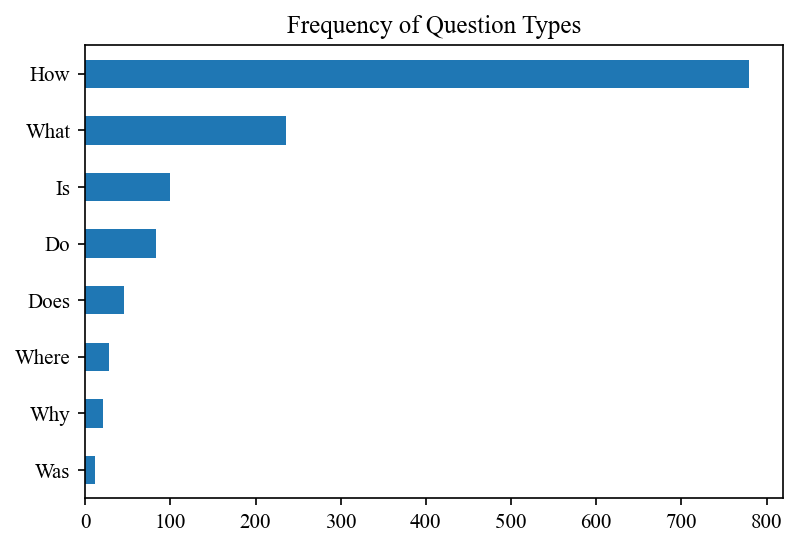

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.dpi'] = 150


counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [9]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)["question"]):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


### 7.1.2 텍스트에서 답 추출하기
### QA를 위한 텍스트 토큰화

In [10]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [11]:
question = "How much music can this hold"
context = """An MP3 is about 1MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [12]:
inputs["input_ids"]

tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,   102,  2019, 23378,
          2003,  2055,  1015, 14905,  1013,  3371,  1010,  2061,  2055, 25961,
          2847,  5834,  2006,  5371,  2946,  1012,   102]])

In [18]:
input_test = tokenizer([question, context], return_tensors="pt", padding=True)
input_test["input_ids"]

tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  2019, 23378,  2003,  2055,  1015, 14905,  1013,  3371,  1010,
          2061,  2055, 25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]])

In [14]:
input_test = tokenizer((question, context), return_tensors="pt", truncation=True, padding=True)
input_test["input_ids"]

tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  2019, 23378,  2003,  2055,  1015, 14905,  1013,  3371,  1010,
          2061,  2055, 25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]])

In [19]:
input_test = tokenizer(*(question, context), return_tensors="pt", truncation=True, padding=True)
input_test["input_ids"]

tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,   102,  2019, 23378,
          2003,  2055,  1015, 14905,  1013,  3371,  1010,  2061,  2055, 25961,
          2847,  5834,  2006,  5371,  2946,  1012,   102]])

In [15]:
tokenizer

BertTokenizerFast(name_or_path='deepset/minilm-uncased-squad2', vocab_size=30522, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [16]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold [SEP] an mp3 is about 1mb / minute, so about 6000 hours depending on file size. [SEP]


In [20]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)

print(outputs)

c:\Users\Kang MinJae\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Kang MinJae\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.4845, -4.7945, -5.1399, -5.0350, -5.1843, -5.4974, -5.2776, -0.4845,
          5.2876,  3.8999,  1.3249,  4.8665,  5.0556, -2.0630, -3.7090, -1.6329,
         -3.3912,  0.1654,  3.8754,  3.5564, -0.8489, -1.3201, -2.2184,  1.3752,
         -1.7700, -1.4017, -0.4845]]), end_logits=tensor([[-0.8425, -5.6538, -5.1782, -4.9850, -5.4860, -5.4552, -5.1084, -0.8425,
         -1.7366,  2.6671, -3.2284, -2.2925, -1.7152, -0.5400, -2.6660,  5.2819,
          1.8558, -2.6281, -3.3308, -1.2718,  4.3964, -0.2450, -4.4068, -1.3508,
          4.2771,  4.2504, -0.8425]]), hidden_states=None, attentions=None)


In [21]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [22]:
print(f"입력 ID 크기: {inputs.input_ids.size()}")
print(f"시작 로짓 크기: {start_logits.size()}")
print(f"종료 로짓 크기: {end_logits.size()}")

입력 ID 크기: torch.Size([1, 27])
시작 로짓 크기: torch.Size([1, 27])
종료 로짓 크기: torch.Size([1, 27])


In [23]:
import torch

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"질문: {question}")
print(f"답변: {answer}")

질문: How much music can this hold
답변: an mp3 is about 1mb / minute


In [26]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, top_k=3)

[{'score': 0.13956491649150848,
  'start': 0,
  'end': 26,
  'answer': 'An MP3 is about 1MB/minute'},
 {'score': 0.11066953837871552,
  'start': 16,
  'end': 26,
  'answer': '1MB/minute'},
 {'score': 0.09160058945417404,
  'start': 10,
  'end': 26,
  'answer': 'about 1MB/minute'}]

In [29]:
pipe(question="Why is there no data?", context=context,
     handle_impossible_answer=True)

{'score': 0.8946091532707214, 'start': 0, 'end': 0, 'answer': ''}

### 긴 텍스트 다루기

In [31]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
                              return_overflowing_tokens=True, truncation=True,
                              max_length=100, stride=25)

In [35]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"#{idx} 윈도에는 {len(window)}개의 토큰이 있습니다.")

#0 윈도에는 100개의 토큰이 있습니다.
#1 윈도에는 88개의 토큰이 있습니다.


In [32]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



### 7.1.3 헤이스택을 사용해 QA 파이프라인 구축하기
### 문서 저장소 초기화하기